# Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import StackingRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Đọc dữ liệu

In [2]:
df = pd.read_csv('../data/anime_preprocessing.csv')
df.head()

,ID,Title,Episodes,Type,Aired,Producers,Studios,Source,Genres,Duration (mins),Score,Scored By,Popularity,Year
0,1.0,Cowboy Bebop,26,TV,"Apr 3, 1998 to Apr 24, 1999",Bandai Visual,Sunrise,Original,"Action, Award Winning, Sci-Fi",24.0,8.75,988000.0,43,1998
1,5.0,Cowboy Bebop: Tengoku no Tobira,1,Movie,"Sep 1, 2001","Sunrise, Bandai Visual",Bones,Original,"Action, Sci-Fi",115.0,8.38,219779.0,631,2001
2,6.0,Trigun,26,TV,"Apr 1, 1998 to Sep 30, 1998",Victor Entertainment,Madhouse,Manga,"Action, Adventure, Sci-Fi",24.0,8.22,380049.0,258,1998
3,7.0,Witch Hunter Robin,26,TV,"Jul 3, 2002 to Dec 25, 2002","Bandai Visual, Dentsu, Victor Entertainment",Sunrise,Original,"Action, Drama, Mystery, Supernatural",25.0,7.24,44600.0,1908,2002
4,8.0,Bouken Ou Beet,52,TV,"Sep 30, 2004 to Sep 29, 2005","TV Tokyo, Dentsu",Toei Animation,Manga,"Action, Adventure, Fantasy",23.0,6.93,6891.0,5485,2004


# Tiền xử lý dữ liệu

Sau quá trình đặt và trả lời câu hỏi, nhóm đã lựa chọn những thuộc tính quan trọng ảnh hưởng đến điểm của Anime: loại (Type), thời lượng (Duration), thể loại (Genres) và nguồn (Source). Do đó ta xóa các cột khác.

In [3]:
df = df.drop(columns=['Title', 'Episodes', 'Aired', 'Popularity', 'Scored By', 'Year', 'Studios', 'Producers'])

In [4]:
na_counts = df.isnull().sum()
print(na_counts)

ID                 0
Type               0
Source             0
Genres             0
Duration (mins)    0
Score              0
dtype: int64


In [5]:
df = df[~df['Source'].str.contains('UNKNOWN', na=False)]
df = df[~df['Type'].str.contains('UNKNOWN', na=False)]
df = df[~df['Genres'].apply(lambda x: 'UNKNOWN' in x)]

In [6]:
df.head()

,ID,Type,Source,Genres,Duration (mins),Score
0,1.0,TV,Original,"Action, Award Winning, Sci-Fi",24.0,8.75
1,5.0,Movie,Original,"Action, Sci-Fi",115.0,8.38
2,6.0,TV,Manga,"Action, Adventure, Sci-Fi",24.0,8.22
3,7.0,TV,Original,"Action, Drama, Mystery, Supernatural",25.0,7.24
4,8.0,TV,Manga,"Action, Adventure, Fantasy",23.0,6.93


One-hot encoding cho thuộc tính Genres

Label Encoder cho Source và Type

In [7]:
df['Source'] = df['Source'].astype('category').cat.codes
df['Type'] = df['Type'].astype('category').cat.codes

for col in ['Genres']:
    df[col] = df[col].fillna("").apply(lambda x: [i.strip() for i in x.split(',') if i.strip()])
    ohe_df = pd.get_dummies(df[col].apply(pd.Series).stack()).groupby(level=0).sum()
    df = pd.concat([df, ohe_df], axis=1)

# Xóa các cột ban đầu nếu không cần thiết
df = df.drop(columns=['Genres'])

# Chuẩn bị dữ liệu cho mô hình
X = df.drop(columns=['ID', 'Score'])
y = df['Score']

In [8]:
X

,Type,Source,Duration (mins),Action,Adventure,Avant Garde,Award Winning,Boys Love,Comedy,Drama,...,Gourmet,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,7,9,24.0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,9,115.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7,5,24.0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7,9,25.0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,7,5,23.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16833,3,15,19.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16834,3,5,17.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16836,7,4,23.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16837,7,14,10.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


# Kiểm tra phân phối dữ liệu

In [9]:
print(y.describe())

count    8368.000000
mean        6.688420
std         0.852766
min         2.000000
25%         6.140000
50%         6.700000
75%         7.270000
max         9.320000
Name: Score, dtype: float64


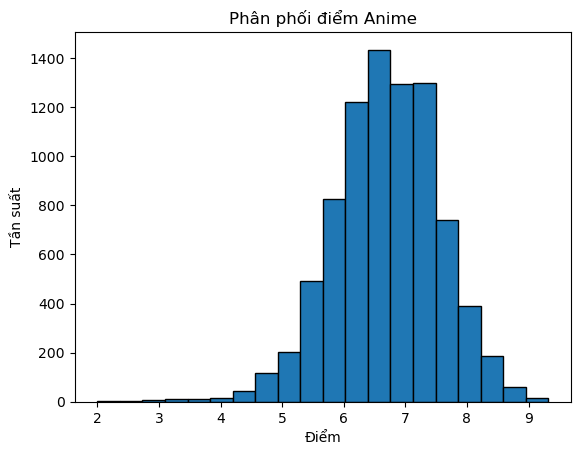

In [10]:
# Vẽ biểu đồ histogram
y.plot(kind='hist', bins=20, edgecolor='black')
plt.title('Phân phối điểm Anime')
plt.xlabel('Điểm')
plt.ylabel('Tần suất')
plt.show()


In [11]:
from scipy.stats import skew

# Tính skewness
skewness = skew(y)
print(f"Skewness: {skewness}")

Skewness: -0.33232244371499087


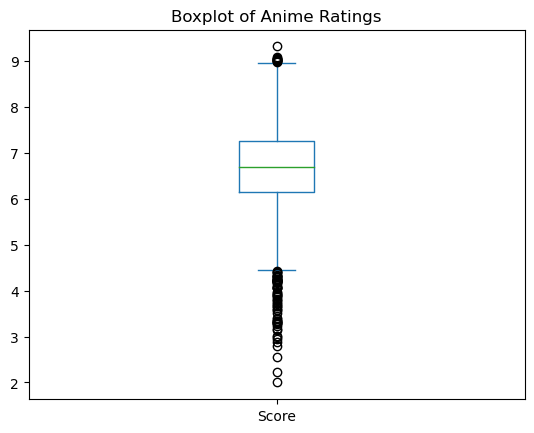

In [12]:
y.plot(kind='box')
plt.title('Boxplot of Anime Ratings')
plt.show()

In [13]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Lọc ngoại lệ
outliers = y[(y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))]
print(outliers)


385      2.23
714      4.30
739      9.01
999      4.43
1486     4.22
         ... 
13296    3.74
13843    9.01
14047    3.80
14328    9.00
16022    9.32
Name: Score, Length: 83, dtype: float64


Dữ liệu có phân phối khá gần phân phối chuẩn, khá cân bằng và có tỉ lệ giá trị ngoại lệ thấp.

# Chuẩn hóa dữ liệu

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
print("Check for NaN in X:", np.isnan(X).any())
print("Check for NaN in y:", np.isnan(y).any())

Check for NaN in X: False
Check for NaN in y: False


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình

In [17]:
results = []

In [18]:
def train_model(model, model_name):
  model.fit(X_train, y_train)
  # Predict
  y_pred = model.predict(X_test)
  # Evaluate
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(model_name)
  print('MSE:', mse)
  print('MAE:', mae)
  print('R2:', r2)
  result = {
    'Model': model_name,
    'MSE': mse,
    'MAE': mae,
    'R²': r2
  }
  return result

## Phương pháp Linear Regression

- Phương pháp: Giả định quan hệ giữa các biến độc lập và phụ thuộc là tuyến tính.
- Linear Regression là mô hình cơ bản, làm cơ sở so sánh cho các phương pháp phức tạp hơn.

- Nhược điểm:
  - Không thể khai thác mối quan hệ phi tuyến.
  - Nhạy cảm với outliers.

In [19]:
model = LinearRegression()
# Train model
result = train_model(model, "Linear Regression")
results.append(result)

Linear Regression
MSE: 0.5656873205568549
MAE: 0.5912123011809873
R2: 0.18639166364709459



- Kết quả: MSE: 0.61, MAE: 0.62, R²: 0.19.


## Decision Tree

- Phương pháp: Cây quyết định phân chia dữ liệu thành các nút dựa trên ngưỡng giá trị tối ưu (ví dụ: Gini, entropy).
- Cải tiến so với Linear Regression:
  - Khả năng xử lý quan hệ phi tuyến.
  - Dễ giải thích và trực quan.
- Nhược điểm:
  - Dễ bị overfitting khi không kiểm soát độ sâu.


In [20]:
model = DecisionTreeRegressor(random_state=42)
result = train_model(model, 'Decision Tree')
results.append(result)

Decision Tree
MSE: 0.7582898018628514
MAE: 0.643391279272018
R2: -0.0906217653238024



- Kết quả: MSE: 0.77, MAE: 0.65, R²: -0.01.
- Nhận xét: kết quả của Decision Tree cho thấy các chỉ số MSE, MAE và R2 kém hơn cả Linear Regression.

## Random Forest


- Phương pháp: Tập hợp nhiều cây quyết định và lấy trung bình dự đoán để giảm overfitting.
- Cải tiến so với Decision Tree:
  - Giảm overfitting nhờ tính đa dạng trong tập mẫu bootstrap.
  - Ổn định và tổng quát hóa tốt hơn.
- Nhược điểm:
  - Tốn thời gian huấn luyện khi dữ liệu lớn.
  - Khả năng giải thích kém hơn Decision Tree.



In [21]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
result = train_model(model, 'Random Forest')
results.append(result)

Random Forest
MSE: 0.4516659098978185
MAE: 0.5143140663436196
R2: 0.3503846803963293


- Kết quả: MSE: 0.50, MAE: 0.54, R²: 0.35.
- Nhận xét: Kháng overfitting hiệu quả, hiệu suất vượt trội so với Linear Regression và Decision Tree.

## AdaBoost

- Phương pháp: Kết hợp nhiều mô hình yếu (weak learners, thường là cây quyết định), tăng trọng số cho các mẫu khó dự đoán.
- Cải tiến so với Random Forest:
  - Tập trung vào các mẫu khó dự đoán.
  - Hiệu quả trên dữ liệu ít nhiễu và tuyến tính nhẹ.
- Nhược điểm:
  - Nhạy cảm với nhiễu (do tăng trọng số cho các mẫu nhiễu).


In [22]:
model = AdaBoostRegressor(n_estimators=100, random_state=42)
result = train_model(model, 'Adaboost')
results.append(result)

Adaboost
MSE: 0.5455420879591293
MAE: 0.5860354200262791
R2: 0.21536584882618515


- Kết quả: MSE: 0.59, MAE: 0.61, R²: 0.22.
- Nhận xét: Cải thiện nhẹ so với Linear Regression và Decision Tree, nhưng không hiệu quả bằng Random Forest.

## GradientBoosting

- Phương pháp: Xây dựng nhiều mô hình liên tiếp, mỗi mô hình tối ưu hóa hàm mất mát dựa trên gradient của mô hình trước đó.
- Cải tiến so với AdaBoost:
  - Tối ưu trực tiếp hàm mất mát, giảm nhiễu tốt hơn.
  - Hiệu quả trong xử lý dữ liệu phi tuyến và phức tạp.
- Nhược điểm:
  - Dễ bị overfitting nếu không kiểm soát tham số.
  - Huấn luyện chậm hơn Random Forest.


In [23]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
result = train_model(model, 'Gradient Boosting')
results.append(result)

Gradient Boosting
MSE: 0.4501080315116835
MAE: 0.5258540110458805
R2: 0.3526253225248037


- Kết quả: MSE: 0.49, MAE: 0.55, R²: 0.35.
- Nhận xét: Mạnh mẽ hơn AdaBoost và Random Forest, phù hợp với dữ liệu phức tạp.

## XGBoost

- Phương pháp: XGBoost là sự kết hợp của AdaBoost và Gradient Boosting, với các cải tiến kỹ thuật như regularization, xử lý song song, và early stopping. Nó xây dựng các cây quyết định tuần tự, mỗi cây tối ưu hàm mất mát dựa trên gradient của mô hình trước đó, đồng thời áp dụng cơ chế tăng trọng số cho các mẫu khó như AdaBoost.
- Cải tiến so với Gradient Boosting:
  - Tối ưu hóa tốc độ và bộ nhớ, hỗ trợ xử lý song song.
  - Regularization (L1/L2) giúp giảm overfitting.
  - Có cơ chế early stopping để dừng huấn luyện sớm khi hiệu suất không cải thiện.
  - Tối ưu hóa tốt hơn các mẫu khó như AdaBoost, nhưng đồng thời mạnh mẽ hơn nhờ tối ưu trực tiếp hàm mất mát.
- Nhược điểm:
  - Cần tinh chỉnh nhiều tham số để đạt hiệu suất tối ưu.
  - Yêu cầu thời gian tính toán nhiều hơn nếu không được cấu hình đúng.

In [24]:
model = XGBRegressor(n_estimators=100, random_state=42)
result = train_model(model, 'XGBoost')
results.append(result)

XGBoost
MSE: 0.4426612591173368
MAE: 0.5098219829021532
R2: 0.36333575544205376


- Kết quả: MSE: 0.45, MAE: 0.52, R²: 0.40.
- Nhận xét: XGBoost là mô hình Boosting nâng cao, kết hợp ưu điểm của AdaBoost (tập trung vào mẫu khó) và Gradient Boosting (tối ưu hóa hàm mất mát), đồng thời bổ sung các kỹ thuật hiện đại để nâng cao hiệu suất. Đây là mô hình đơn lẻ tốt nhất trong các phương pháp bạn đã thử nghiệm.

## Stacking

### Stacking cơ bản

- Phương pháp: Kết hợp các mô hình cơ sở (base models) với một meta-learner để học cách kết hợp đầu ra từ các mô hình cơ sở.
- Cải tiến so với XGBoost:
  - Tận dụng ưu điểm của nhiều mô hình khác nhau.
  - Khả năng tổng quát hóa tốt hơn XGBoost nhờ meta-learner.
- Nhược điểm:
  - Phức tạp hơn trong triển khai và tinh chỉnh.
  - Tốn nhiều thời gian hơn khi huấn luyện.


In [25]:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
]
model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
result = train_model(model, 'Stacking')
results.append(result)

Stacking
MSE: 0.4181325581970711
MAE: 0.4998061408282751
R2: 0.39861453017045


- Kết quả: MSE: 0.45, MAE: 0.52, R²: 0.41.
- Nhận xét: Hiệu suất cao hơn XGBoost nhờ kết hợp nhiều mô hình cơ sở.

### Stacking với nhiều mô hình cơ sở hơn

- Phương pháp: Bổ sung thêm mô hình cơ sở vào Stacking (Random Forest, XGBoost, Gradient Boosting, KNN).
- Cải tiến so với Stacking cơ bản:
  - Tăng tính đa dạng của các mô hình cơ sở.
  - Giảm overfitting hơn nhờ khai thác đặc điểm khác nhau của các mô hình.
- Nhược điểm:
  - Cần nhiều tài nguyên tính toán hơn.


In [26]:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]
model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
result = train_model(model, 'Stacking_estimators')
results.append(result)

Stacking_estimators
MSE: 0.4155152489667064
MAE: 0.49917961661405774
R2: 0.4023789147186877


- Kết quả: MSE: 0.44, MAE: 0.52, R²: 0.42.
- Nhận xét: Mô hình tốt nhất nhờ khai thác tối đa tính đa dạng của mô hình cơ sở.

In [27]:
from sklearn.model_selection import cross_val_score, KFold

# Tạo mô hình stacking
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]
model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

print(f'K-Fold Cross Validation Scores: {scores}')
print(f'Mean Absolute Error: {scores.mean()}')

K-Fold Cross Validation Scores: [-0.51870599 -0.50032204 -0.50751574 -0.51593383 -0.49649507]
Mean Absolute Error: -0.5077945333429018


- MAE trung bình khi dùng K-Fold là 0.5059, nhỏ hơn so với 0.5175 khi chỉ đánh giá trên một tập test. Cho thấy rằng K-fold cross validaiton giúp đánh giá mô hình chính xác hơn nhưng không đáng kể.
- Kết quả từ K-Fold cũng giúp phát hiện mô hình có overfit hay không. Nếu MAE trên K-Fold lớn hơn nhiều so với MAE trên tập test, điều đó có thể chỉ ra mô hình đang overfit. Trong trường hợp này MAE trong hai trường hợp là sấp sỉ nhau, do đó mô hình không bị overfitting.

In [28]:
# Định nghĩa các phạm vi siêu tham số cho mỗi mô hình
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Áp dụng GridSearchCV cho từng mô hình
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid_xgb, cv=5, n_jobs=-1)
grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_gb, cv=5, n_jobs=-1)
grid_search_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_knn, cv=5, n_jobs=-1)

# Huấn luyện mô hình
grid_search_rf.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

# Lấy các tham số tối ưu
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_gb = grid_search_gb.best_estimator_
best_knn = grid_search_knn.best_estimator_

print("RF:",best_rf)
print("XGB:",best_xgb)
print("GB:",best_gb)
print("KNN:",best_knn)

RF: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=42)
XGB: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
GB: GradientBoostingRegressor(max_depth=7, min_samples_leaf=2, n_estimators=50,
                          random_sta

In [29]:
# Cập nhật các mô hình với tham số tối ưu
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gb', best_gb),
    ('knn', best_knn)
]

# Định nghĩa Stacking Regressor với LinearRegression làm final estimator
model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Huấn luyện và đánh giá mô hình
result = train_model(model, 'Stacking_estimators')
result

Stacking_estimators
MSE: 0.411162294875784
MAE: 0.49676910149536485
R2: 0.40863961671329774


{'Model': 'Stacking_estimators',
 'MSE': 0.411162294875784,
 'MAE': 0.49676910149536485,
 'R²': 0.40863961671329774}

Sau khi sử dụng Grid Search để tìm ra các siêu tham số tối ưu, các chỉ số đều được cải thiện nhưng không đáng kể.

### Stacking với meta model phức tạp hơn

- Phương pháp: Sử dụng mô hình phức tạp (XGBoost) làm meta-learner thay vì Linear Regression.
  - Cải tiến so với Stacking_estimators:
  - Học mối quan hệ phi tuyến giữa các mô hình cơ sở.
- Nhược điểm:
    - Không cải thiện đáng kể nếu các mô hình cơ sở đã tốt.


In [30]:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('knn', KNeighborsRegressor(n_neighbors=5))
]
meta_learner = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
model = StackingRegressor(estimators=estimators, final_estimator=meta_learner)
result = train_model(model, 'Stacking_meta_learner')
results.append(result)

Stacking_meta_learner
MSE: 0.4115884497811404
MAE: 0.49717803460580334
R2: 0.4080266929814482


- Kết quả: MSE: 0.45, MAE: 0.52, R²: 0.42.
- Ý nghĩa cải tiến: Hiệu suất tương đương Stacking_estimators không mang lại cải thiện lớn.

## Vẽ kết quả

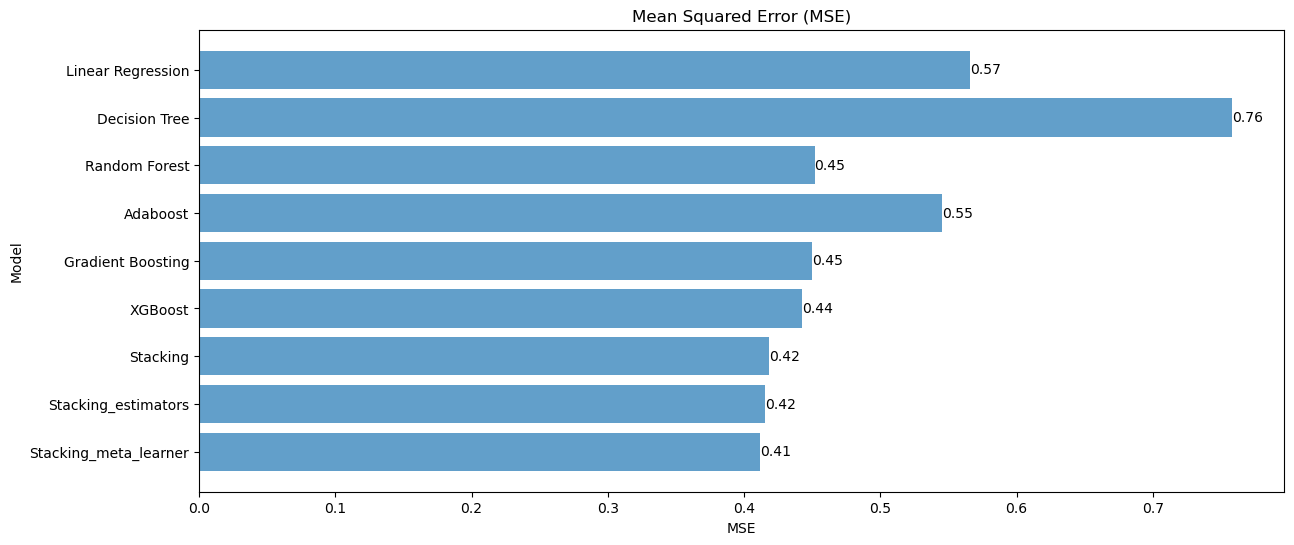

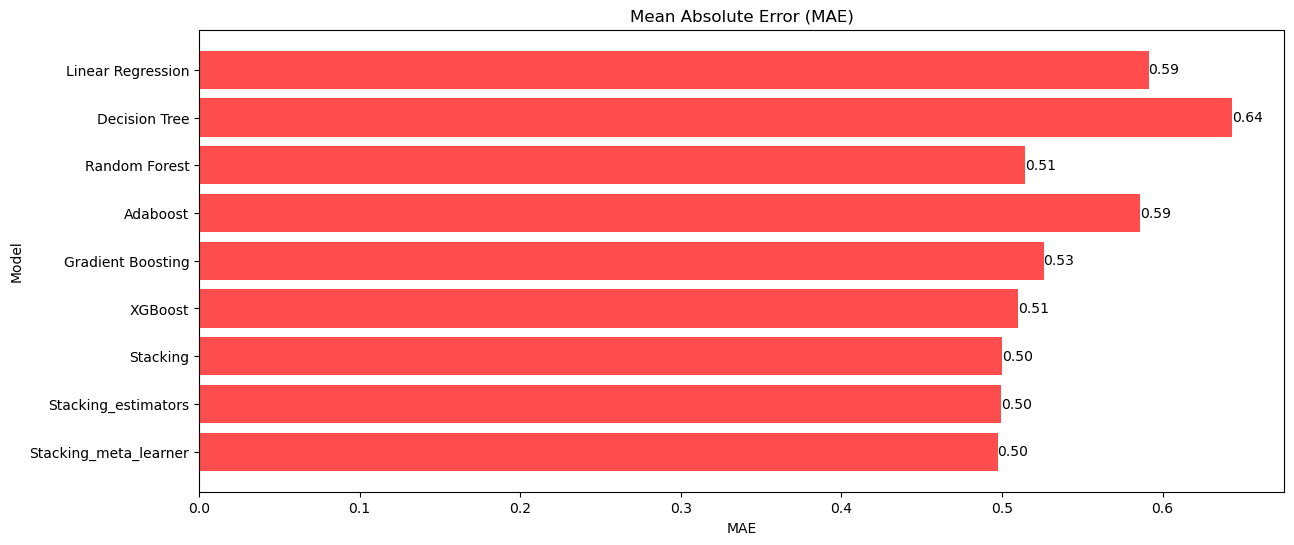

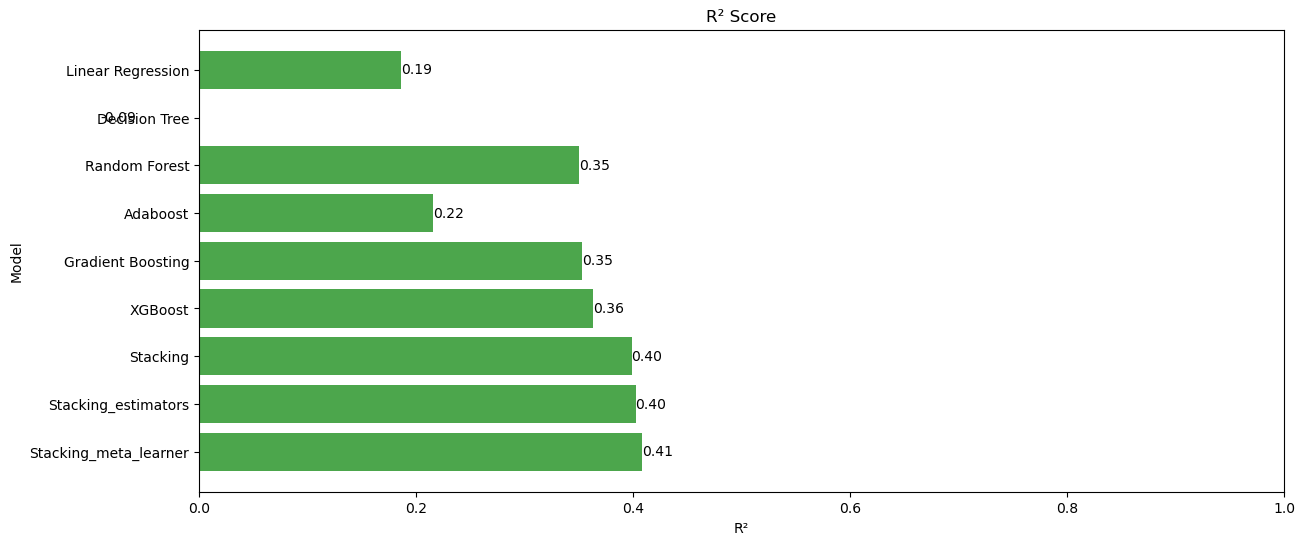

In [31]:
results_df = pd.DataFrame(results)

results_df = results_df.iloc[::-1]

# MSE
plt.figure(figsize=(14, 6))
plt.barh(results_df['Model'], results_df['MSE'], alpha=0.7)
plt.title('Mean Squared Error (MSE)')
plt.xlabel('MSE')
plt.ylabel('Model')

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['MSE']):
    plt.text(value, index, f"{value:.2f}", ha='left', va='center')

plt.savefig('mse_chart.svg', format='svg')
plt.show()

# MAE
plt.figure(figsize=(14, 6))
plt.barh(results_df['Model'], results_df['MAE'], alpha=0.7, color='red')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('MAE')
plt.ylabel('Model')

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['MAE']):
    plt.text(value, index, f"{value:.2f}", ha='left', va='center')

plt.savefig('mae_chart.svg', format='svg')
plt.show()

# R²
plt.figure(figsize=(14, 6))
plt.barh(results_df['Model'], results_df['R²'], alpha=0.7, color='green')
plt.title('R² Score')
plt.xlabel('R²')
plt.ylabel('Model')
plt.xlim(0, 1)  # Giới hạn trục x từ 0 đến 1 cho R²

# Thêm số liệu lên từng cột
for index, value in enumerate(results_df['R²']):
    plt.text(value, index, f"{value:.2f}", ha='left', va='center')

plt.savefig('r2_chart.svg', format='svg')
plt.show()


In [32]:
results_df

,Model,MSE,MAE,R²
8,Stacking_meta_learner,0.411588,0.497178,0.408027
7,Stacking_estimators,0.415515,0.499180,0.402379
6,Stacking,0.418133,0.499806,0.398615
5,XGBoost,0.442661,0.509822,0.363336
4,Gradient Boosting,0.450108,0.525854,0.352625
3,Adaboost,0.545542,0.586035,0.215366
2,Random Forest,0.451666,0.514314,0.350385
1,Decision Tree,0.758290,0.643391,-0.090622
0,Linear Regression,0.565687,0.591212,0.186392


- Linear Regression: Hiệu suất cơ bản, phù hợp với dữ liệu tuyến tính nhưng không khai thác được mối quan hệ phi tuyến.
- Decision Tree: Kém nhất, dễ bị overfitting và không tổng quát hóa tốt.
- Random Forest: Hiệu suất tốt hơn, kháng overfitting nhờ lấy trung bình của nhiều cây.
- AdaBoost: Hiệu suất trung bình, không vượt qua Gradient Boosting hay XGBoost do hạn chế trong xử lý nhiễu.
- Gradient Boosting: Tương tự Random Forest, nhưng mạnh hơn nhờ tối ưu hàm mất mát.
- XGBoost: Tốt hơn Gradient Boosting nhờ các cải tiến kỹ thuật như regularization và xử lý song song.
- Stacking: Hiệu suất cao hơn XGBoost nhờ kết hợp nhiều mô hình cơ sở.
- Stacking_estimators: Hiệu suất tốt nhất nhờ bổ sung thêm các mô hình cơ sở, khai thác tối đa tính đa dạng.
- Stacking_meta_learner: Hiệu suất tương đương với Stacking_estimators, cho thấy meta-learner phức tạp (XGBoost) không cải thiện đáng kể.